In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
epi_dir = '/Volumes/umms-esnitkin/Project_KPC_LTACH/Analysis/LTACH_transmission_modeling'

In [ ]:
infections_cleaned = pd.read_csv(f"{epi_dir}/preprocessed/infections.csv", index_col=0)
infections_cleaned.columns = np.arange(367)

df_screen = pd.read_csv(f"{epi_dir}/preprocessed/screening.csv", index_col=0)
df_screen.columns = np.arange(367)

df_floor = pd.read_csv(f"{epi_dir}/preprocessed/floor_trace.csv", index_col=0)
df_floor.columns = np.arange(367)

df_room = pd.read_csv(f"{epi_dir}/preprocessed/room_trace.csv", index_col=0)
df_room.columns = np.arange(367)

In [6]:
window_starts = [i*7 for i in range(367//7 + 1)]

window_stops = [w -1 for w in window_starts[1:]] + [367]

windows = list(zip(window_starts, window_stops))

In [7]:
infections_rs = pd.DataFrame(index=infections_cleaned.index, columns=np.arange(len(windows)))
for n in infections_cleaned.index:
    for t, w in enumerate(windows):
        a, b = w
        week_data = infections_cleaned.loc[n, a:b]
        if np.isnan(week_data).all():
            infections_rs.loc[n, t] = np.nan
        else:
            infections_rs.loc[n, t] = np.nanmax(week_data)

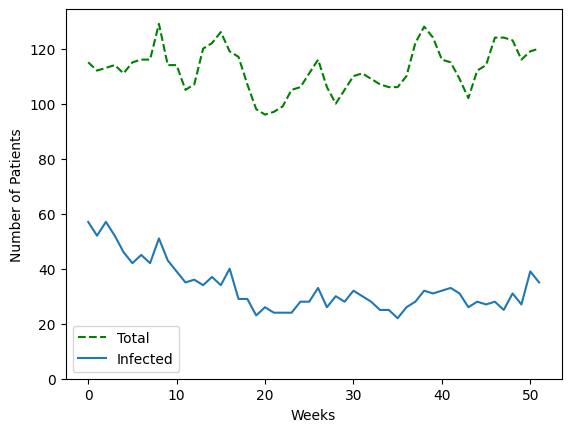

In [29]:
NN = infections_rs.notna().sum(0)[:-1]
II = (infections_rs == 1).sum(0)[:-1]
sns.lineplot(NN, color="green", linestyle="--", label="Total")
sns.lineplot(II, label="Infected")
plt.ylim(bottom=0)
plt.ylabel("Number of Patients")
plt.xlabel("Weeks")
plt.savefig("images/crkp.png")
plt.show()

(0.0, 1.0)

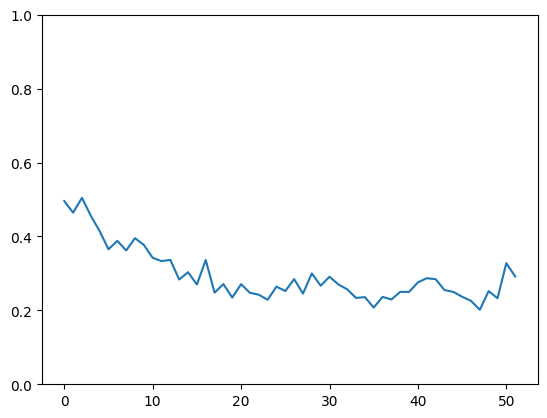

In [32]:
sns.lineplot(II / NN)
plt.ylim(0,1)

In [70]:
df_facility_rs = infections_rs.notna().astype(int)

In [27]:
NN.mean()

112.65384615384616

#### screening data

In [16]:
df_screen_rs = pd.DataFrame(index=infections_cleaned.index, columns=np.arange(len(windows)))
for n in df_screen.index:
    admitted = False
    for t, w in enumerate(windows):
        a, b = w
        week_data = df_screen.loc[n, a:b]
        if not np.isnan(week_data).all():
            df_screen_rs.loc[n, t] = np.nanmax(week_data)
        # if np.isnan(week_data).all():
        #     infections_rs.loc[n, t] = np.nan
        # else:
        #     infections_rs.loc[n, t] = np.nanmax(week_data)

In [23]:
A = df_screen_rs.sum(0)
B = df_screen_rs.notna().sum(0)

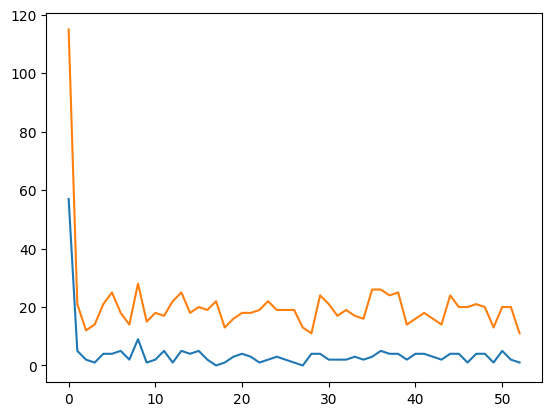

In [25]:
sns.lineplot(A)
sns.lineplot(B)
plt.show()

In [26]:
B[1:].mean()

18.807692307692307

In [30]:
A[1:].mean()

2.9423076923076925

### floor and room trace data

In [53]:
df_floor.columns

Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       357, 358, 359, 360, 361, 362, 363, 364, 365, 366],
      dtype='int64', length=367)

In [60]:
df_floor_rs = pd.DataFrame(index=df_floor.index, columns=np.arange(len(windows)))
for n in df_floor.index:
    admitted = False
    for t, w in enumerate(windows):
        a, b = w
        week_data = np.array(df_floor.loc[n, a:b])
        df_floor_rs.loc[n, t] = week_data[np.argmax(week_data > 0)]
        # if not np.isnan(week_data).all():
        #     df_screen_rs.loc[n, t] = np.nanmax(week_data)

In [65]:
df_room_rs = pd.DataFrame(index=df_room.index, columns=np.arange(len(windows)))
for n in df_room.index:
    admitted = False
    for t, w in enumerate(windows):
        a, b = w
        week_data = np.array(df_room.loc[n, a:b])
        df_room_rs.loc[n, t] = week_data[np.argmax(week_data > 0)]

In [66]:
df_room_rs

,0,1,2,3,4,5,6,7,8,9,...,43,44,45,46,47,48,49,50,51,52
1,1,1,2,4,4,4,5,5,5,5,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,12,12,12,12,12,12,12,0,0,0
3,14,10,15,15,15,15,15,15,15,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,18,18,20,21,21,21,21,21,21,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1426,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1427,0,0,0,0,0,10,72,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1428,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1429,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## "observed" data

In [75]:
total_count = infections_rs.sum(0).values

array([[1.0, 1.0, 1.0, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [1.0, 1.0, 1.0, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [0.0, 0.0, 0.0, ..., nan, nan, nan]], dtype=object)

In [76]:
floor_counts = []
X = infections_rs.values
F = df_floor_rs.values
for i in range(1,7):
    # does this work with matrix indexing?
    floor_count = np.nansum(X * (F == i), axis=0)
    floor_counts.append(floor_count)

In [79]:
T = X.shape[1]
room_count = np.zeros(T)
room_count2 = np.zeros(T)
R = df_room_rs.values
r = np.zeros(T).astype(int)
x = np.zeros(T)
w = np.zeros(T)
for t in range(T):
    rx, ry = np.meshgrid(r, r)
    rC = (rx == ry).astype(int)
    I = (x == 1).astype(int)
    infected_roommates = (rC * I).sum(1) 
    room_count[t] = (infected_roommates > 1).sum() / 2
    r = R[:, t]
    x = X[:, t]

In [ ]:
observed_data = np.stack([total_count] + floor_counts + [room_count])

In [94]:
observed_data = observed_data.astype(float)

#### write out data

In [71]:
# takeaway from sanity check: each week sees about 20 new patients admitted

output_dir = '/Volumes/umms-esnitkin/Project_KPC_LTACH/Analysis/LTACH_transmission_modeling/preprocessed/resampled'
infections_rs.to_csv(f"{output_dir}/infections.csv")
df_screen_rs.to_csv(f"{output_dir}/screening.csv")
df_facility_rs.to_csv(f"{output_dir}/facility_trace.csv")
df_floor_rs.to_csv(f"{output_dir}/floor_trace.csv")
df_room_rs.to_csv(f"{output_dir}/room_trace.csv")


In [95]:
with open(f"{output_dir}/observed_data.npy", "wb") as f:
    np.save(f, observed_data)

In [86]:
floor_counts

[array([4.0, 11.0, 14.0, 17.0, 14.0, 17.0, 16.0, 14.0, 18.0, 14.0, 10.0,
        12.0, 12.0, 11.0, 12.0, 13.0, 14.0, 9.0, 3.0, 3.0, 3.0, 5.0, 0.0,
        0.0, 1.0, 0.0, 1.0, 4.0, 7.0, 7.0, 8.0, 10.0, 8.0, 6.0, 4.0, 5.0,
        6.0, 6.0, 8.0, 10.0, 7.0, 8.0, 6.0, 5.0, 6.0, 6.0, 5.0, 5.0, 4.0,
        4.0, 6.0, 8.0, 6.0], dtype=object),
 array([16.0, 6.0, 7.0, 1.0, 4.0, 1.0, 2.0, 1.0, 4.0, 3.0, 4.0, 1.0, 3.0,
        1.0, 3.0, 3.0, 3.0, 0.0, 3.0, 2.0, 3.0, 1.0, 4.0, 1.0, 3.0, 3.0,
        5.0, 0.0, 3.0, 1.0, 1.0, 2.0, 3.0, 0.0, 3.0, 2.0, 2.0, 2.0, 4.0,
        2.0, 5.0, 4.0, 4.0, 1.0, 2.0, 2.0, 1.0, 2.0, 6.0, 3.0, 6.0, 0.0,
        2.0], dtype=object),
 array([19.0, 27.0, 25.0, 24.0, 19.0, 18.0, 20.0, 20.0, 20.0, 20.0, 18.0,
        13.0, 13.0, 15.0, 18.0, 11.0, 16.0, 16.0, 19.0, 12.0, 14.0, 15.0,
        18.0, 17.0, 19.0, 20.0, 21.0, 17.0, 13.0, 14.0, 16.0, 14.0, 11.0,
        11.0, 8.0, 8.0, 7.0, 10.0, 11.0, 13.0, 15.0, 15.0, 16.0, 16.0,
        15.0, 14.0, 17.0, 11.0, 13.0, 13.0, 17